In [1]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data\\names\\*.txt'))

import unicodedata
import string

['data\\names\\Arabic.txt', 'data\\names\\Chinese.txt', 'data\\names\\Czech.txt', 'data\\names\\Dutch.txt', 'data\\names\\English.txt', 'data\\names\\French.txt', 'data\\names\\German.txt', 'data\\names\\Greek.txt', 'data\\names\\Irish.txt', 'data\\names\\Italian.txt', 'data\\names\\Japanese.txt', 'data\\names\\Korean.txt', 'data\\names\\Polish.txt', 'data\\names\\Portuguese.txt', 'data\\names\\Russian.txt', 'data\\names\\Scottish.txt', 'data\\names\\Spanish.txt', 'data\\names\\Vietnamese.txt']


In [2]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_letters

57

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('\\')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(all_categories)
# print(category_lines)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [6]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning names into tensor

In [7]:
import torch
import torch.nn as nn

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


# Creating the network
![](https://i.imgur.com/Z2xbySO.png)

In [32]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# Inspact shapes in between transformation inside the model

In [33]:
input = letterToTensor("A")
print(input.shape)
input

torch.Size([1, 57])


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [34]:
hidden = torch.zeros(1, n_hidden)

# pass into network
output, next_hidden = rnn(input, hidden)

print(output.shape)
print(next_hidden.shape)
output

torch.Size([1, 18])
torch.Size([1, 128])


tensor([[-2.8467, -2.8794, -2.7891, -2.9231, -2.8286, -2.7838, -2.9009,
         -2.9187, -2.8710, -2.9459, -2.9339, -2.9883, -2.9768, -3.0129,
         -3.0360, -2.8099, -2.8550, -2.7804]])

In [35]:
torch.cat((input, hidden), 1).shape

torch.Size([1, 185])

# Training

## Preparing training data

In [36]:
top_n, top_i = output.topk(1)
print(top_n, top_i)

tensor([[-2.7804]]) tensor([[ 17]])


In [37]:
category_i = top_i[0].item()
category_i

17

In [38]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


### We will also want a quick way to get a training example (a name and its language)

In [39]:
import random

In [40]:
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)       # Choose a random language
    line = randomChoice(category_lines[category]) # Choose a random name of this language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Beltz
category = Korean / line = Seo
category = Irish / line = Mcguire
category = Spanish / line = Castillion
category = Irish / line = Ceallach
category = Spanish / line = Valencia
category = Irish / line = Mclain
category = Italian / line = Fiscella
category = Chinese / line = Qin
category = Scottish / line = Allan


In [41]:
line_tensor.shape

torch.Size([5, 1, 57])

In [42]:
category_tensor.shape

torch.Size([1])

## Training the network

In [48]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [44]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 2.7465 Wilson / Greek ✗ (English)
10000 10% (0m 7s) 2.0387 Dehmel / German ✗ (Czech)
15000 15% (0m 12s) 1.3527 Feng / Korean ✗ (Chinese)
20000 20% (0m 16s) 1.6483 Ieyoshi / Polish ✗ (Japanese)
25000 25% (0m 20s) 0.2571 Hasekura / Japanese ✓
30000 30% (0m 24s) 2.2388 Ton / Korean ✗ (Vietnamese)
35000 35% (0m 31s) 1.9518 Adrichem / Polish ✗ (Dutch)
40000 40% (0m 37s) 2.0025 Morrison / English ✗ (Scottish)
45000 45% (0m 43s) 0.0852 Antimisiaris / Greek ✓
50000 50% (0m 47s) 1.9491 Craig / Arabic ✗ (Scottish)
55000 55% (0m 52s) 1.9701 Wildgrube / Scottish ✗ (German)
60000 60% (0m 58s) 3.1525 Rompa / Czech ✗ (Dutch)
65000 65% (1m 4s) 0.3103 Yamaoka / Japanese ✓
70000 70% (1m 8s) 1.9230 Rietveld / English ✗ (Dutch)
75000 75% (1m 13s) 0.2926 Sun / Korean ✓
80000 80% (1m 18s) 0.9195 an / Vietnamese ✓
85000 85% (1m 23s) 0.1200 O'Neal / Irish ✓
90000 90% (1m 27s) 2.4423 Gosselin / Arabic ✗ (French)
95000 95% (1m 31s) 0.7143 Bishara / Arabic ✓
100000 100% (1m 36s) 0.9963 Lieu / Vie

# Plotting the result

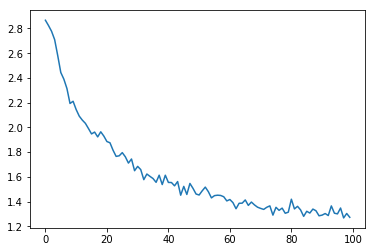

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

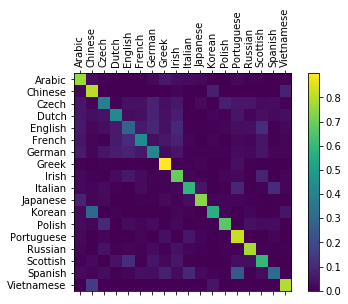

In [46]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()